In [1]:
import os
from pathlib import Path
from pyfaidx import Fasta
import torch
import shutil
import gzip
import random
from typing import Optional, Union, Dict, List
#set seed for random
random.seed(42)
import collections
SPECIES_CHROMOSOME_SPLITS = {
    'human' : {
        'train' : [ '2', '4', '6', '8','14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    },
    'lemur' : {
        'train' : [ '2', '4', '6', '8','14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', 'X', 'Y', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    },
    'goat' : {
        'train' : [ '2', '4', '6', '8','14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 'X', 'Y', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    },
    'sheep' : {
        'train' : [ '2', '4', '6', '8','14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', 'X', 'Y', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    },
    'pig' : {
        'train' : [ '2', '4', '6', '8','14', '15', '16', '17', '18', 'X', 'Y', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    },
    'mouse' : {
        'train' : [ '2', '4', '6', '8', '14', '15', '16', '17', '18', '19', 'X', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    },
    'gorilla' : {
        'train' : [ '2A', '2B', '4', '6', '8', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    },
    'orangutan' : {
        'train' : [ '2A', '2B', '4', '6', '8', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    },
    'chimpanzee' : {
        'train' : [ '2A', '2B', '4', '6', '8', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    },
    'hippo' : {
        'train' : [ '2', '4', '6', '8', '14', '15', '16', '17', 'X', ],
        'valid' : ['1', '3', '12', '13',],
        'test' : [ '5', '7', '9', '10', '11',],
    }
}

fastas: Dict[str, Dict[str, Fasta]] = collections.defaultdict(dict) # [key] = species -> dict where [key] = chromosome, [value] = Fasta object
chromosomes: Dict[str, List[str]] = {} # [key] = species, [value] = list of chromosomes in this split
chromosome_weights: Dict[str, List[float]] = {} # [key] = species, [value] = list where [idx] = self.chromosomes[species][idx], [value] = weight
species_weights: List[float] = []
species=['human','mouse','hippo','pig','lemur']
species_dir='/liuzicheng/ljh/hyena-dna/data/species'
max_length=3000
split='valid'
chromosome_weights='uniform'
species_weights='uniform'
for spec in species:
            species_path = Path(species_dir) / spec
            assert species_path.exists(), f'The path `{species_path}` does not exist for species `{spec}`. Please point to a valid directory containing your species fna.gz files.'

            # Select chromosomes for this split
            assert spec in SPECIES_CHROMOSOME_SPLITS, f'Unrecognized species `{spec}`. Valid species are: {list(SPECIES_CHROMOSOME_SPLITS.keys())}.'
            chromosomes[spec] = SPECIES_CHROMOSOME_SPLITS[spec][split]

            # Load all .fna files of chromosomes in this split
            for chromosome in chromosomes[spec]:
                # Unzip if necessary
                gz_file_path = os.path.join(species_path, f'chr{chromosome}.fna.gz')
                if os.path.exists(gz_file_path) and not (
                    os.path.exists(os.path.join(species_path, f'chr{chromosome}.fna')) or
                    os.path.exists(os.path.join(species_path, f'chr{chromosome}.fa'))
                ):
                    
                    print(f"Unzipping {gz_file_path}...")
                    with gzip.open(gz_file_path, 'rb') as f_in:
                        with open(os.path.join(species_path, f'chr{chromosome}.fna'), 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                # Read .fna or .fa file, whichever we can find
                file_paths = [ os.path.join(species_path, x) for x in [ f'chr{chromosome}.fna', f'chr{chromosome}.fa' ] ]
                is_file_found: bool = False
                for file_path in file_paths:
                    if os.path.exists(file_path):
                        if chromosome not in fastas[spec]:
                            fastas[spec][chromosome] = Fasta(file_path, sequence_always_upper=True)
                        is_file_found = True
                if not is_file_found:
                    raise FileNotFoundError(f'Could not find any of these files: `{file_paths}`. Please point to a valid directory containing all .fna files for species `{spec}`.\nExpected chromosomes: {self.chromosomes[spec]}.')

            
            print(f"Species: {spec}")
            print(f"Split: {split}")
            print(f"Chromosomes: {chromosomes[spec]}")
            print(f"Loaded {len(fastas[spec])} FASTA files from {species_path}: {list(fastas[spec].keys())}")

if isinstance(chromosome_weights, dict):
    assert len(chromosome_weights) == len(species), f"`chromosome_weights` must have a weight for each species. Expected {len(species)} weights, instead got {len(chromosome_weights)}."
    chromosome_weights = chromosome_weights
elif chromosome_weights == 'uniform':
    chromosome_weights = {
        spec: 'uniform'
        for spec in species
    }
elif chromosome_weights == 'weighted_by_bp':
    chromosome_weights = {
        spec: 'weighted_by_bp'
        for spec in species
    }
else:
    raise ValueError(f"Invalid chromosome_weights: {chromosome_weights}. Must be 'uniform', 'weighted_by_bp', or a dict of species -> chromosome weights.")

for spec, strategy_or_weights in chromosome_weights.items():
    if isinstance(strategy_or_weights, str):
        if strategy_or_weights == 'uniform':
            # Uniform weights
            chromosome_weights[spec] = [1] * len(chromosomes[spec])
        elif strategy_or_weights == 'weighted_by_bp':
            # Weight by number of base pairs in each chromosome
            chromosome_weights[spec] = [
                len(fastas[spec][chromosome])
                for chromosome in chromosomes[spec]
            ]
            chromosome_weights[spec] = [w / sum(chromosome_weights[spec]) for w in chromosome_weights[spec]]
        else:
            raise ValueError(f"Invalid chromosome_weights strategy: {strategy_or_weights}. Must be 'uniform' or 'weighted_by_bp'.")
    elif isinstance(strategy_or_weights, list):
        # Check that all chromosomes are accounted for
        assert set(strategy_or_weights.keys()) == set(chromosomes[spec]), f"`chromosome_weights` must have a weight for each chromosome. Expected {chromosomes[spec]}, instead got {strategy_or_weights.keys()}."
        chromosome_weights[spec] = strategy_or_weights
    else:
        raise ValueError(f"Invalid chromosome_weights: {chromosome_weights}. Must be 'uniform', 'weighted_by_bp', or a dict of species -> chromosome weights.")
    
# Set species weights for sampling
if isinstance(species_weights, list):
    assert len(species_weights) == len(species), f"`species_weights` must have a weight for each species. Expected {len(species)} weights, instead got {len(species_weights)}."
    species_weights = species_weights
elif species_weights == 'uniform':
    # Uniform weights
    species_weights = [1] * len(species)
elif species_weights == 'weighted_by_bp':
    # Weight by number of base pairs in each chromosome
    species_weights = [
        sum([ 
            len(fasta) 
            for fasta in fastas[spec].values() 
        ])
        for spec in species
    ]
    species_weights = [w / sum(species_weights) for w in species_weights]
else:
    raise ValueError(f"Invalid species_weights: {species_weights}. Must be 'uniform', 'weighted_by_bp', or a dict of species -> chromosome weights.")
    

print(f"Species weights: {list(zip(species, species_weights))}")
print(f"Chromosome weights: {chromosome_weights}")

Species: human
Split: valid
Chromosomes: ['1', '3', '12', '13']
Loaded 4 FASTA files from /liuzicheng/ljh/hyena-dna/data/species/human: ['1', '3', '12', '13']
Species: mouse
Split: valid
Chromosomes: ['1', '3', '12', '13']
Loaded 4 FASTA files from /liuzicheng/ljh/hyena-dna/data/species/mouse: ['1', '3', '12', '13']
Species: hippo
Split: valid
Chromosomes: ['1', '3', '12', '13']
Loaded 4 FASTA files from /liuzicheng/ljh/hyena-dna/data/species/hippo: ['1', '3', '12', '13']
Species: pig
Split: valid
Chromosomes: ['1', '3', '12', '13']
Loaded 4 FASTA files from /liuzicheng/ljh/hyena-dna/data/species/pig: ['1', '3', '12', '13']
Species: lemur
Split: valid
Chromosomes: ['1', '3', '12', '13']
Loaded 4 FASTA files from /liuzicheng/ljh/hyena-dna/data/species/lemur: ['1', '3', '12', '13']
Species weights: [('human', 1), ('mouse', 1), ('hippo', 1), ('pig', 1), ('lemur', 1)]
Chromosome weights: {'human': [1, 1, 1, 1], 'mouse': [1, 1, 1, 1], 'hippo': [1, 1, 1, 1], 'pig': [1, 1, 1, 1], 'lemur': [1,

In [2]:
def group_by_kmer(seq: str, kmer: int) -> str:
        return " ".join(seq[i : i + kmer] for i in range(0, len(seq), kmer)).upper()

def sample_sequence(species, chromosomes, species_weights, chromosome_weights, fastas, max_length,tokenizer,tokenizer_name):
    spec: str = random.choices(species, weights=species_weights, k=1)[0]
    chromosome = random.choices(chromosomes[spec], weights=chromosome_weights[spec], k=1)[0]
    fasta = fastas[spec][chromosome][0] # idx into 0 b/c only one fasta per chromosome
    chromosome_length: int = len(fasta)
    left = 0
    right = chromosome_length - max_length
    start: int = random.randint(left, right)
    end: int = start + max_length
    seq = str(fasta[start:min(end, right)])

    # pad with Ns if necessary
    seq = seq.rjust(end - start, "N")
    seq = seq[:max_length]

    
    assert len(seq) == max_length, f'Length of sequence ({len(seq)}) from interval ({start}, {end}) of chromosome {chromosome} (len={chromosome_length}) is not equal to `self.max_length` ({self.max_length})'


    # print(f"Sampled species: {spec}")
    # print(f"Sampled chromosome: {chromosome}")
    # print(f"Sampled sequence ({start}, {end}) of len={len(seq)}: {seq[:10]}...{seq[-10:]}")
    
    assert tokenizer is not None, f"Tokenizer cannot be `None`."
    if(tokenizer_name == 'genslm' or tokenizer_name == 'bert'):
            seq = group_by_kmer(seq, 3)
    elif tokenizer_name == 'char':
        seq = tokenizer(seq, add_special_tokens=False)  # add cls and eos token (+2)
        seq = seq["input_ids"]  # get input_ids
        # need to handle eos here
        
    elif tokenizer_name == 'bpe':
        seq = tokenizer(seq, 
            padding="max_length",
            max_length=max_length,
            truncation=True,
        )  # add cls and eos token (+2)
        # get input_id
    else:
        # raise ValueError(f"Invalid tokenizer name: {self.tokenizer_name}")
        seq = tokenizer(seq,
            add_special_tokens= False,  # this is what controls adding eos
            padding="max_length",
            max_length=max_length,
            truncation=True,
        )
        seq = seq["input_ids"]

    # convert to tensor
    seq = torch.LongTensor(seq)  # hack, remove the initial cls tokens for now

    data = seq[:-1].clone()  # remove eos
    target = species.index(spec)

    
        
    return data, target

restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[..., -1:, :]   

In [3]:
#load model from automodel

import torch
from transformers import AutoModel,AutoTokenizer
state_dict='/liuzicheng/ljh/hyena-dna/weight/hyenadna/hyenadna-large-1m-seqlen'
tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
hyenaDNA=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
hyenaDNA_decoder=torch.nn.Linear(256,5).to('cuda')
checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-04-07/01-43-51-388066/checkpoints/val/accuracy.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "model.backbone."
    )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "decoder.0.output_transform."
    )
#print model.keys()
hyenaDNA.load_state_dict(checkpoint,strict=False)
hyenaDNA_decoder.load_state_dict(checkpoint,strict=False)
hyenaDNA.eval()
hyenaDNA_decoder.eval()
all_embeddings_hyena=[]
species_labels_hyena=[]
batch_size=1000
#load data
equal=0
for i in range (batch_size):
    data,target=sample_sequence(species,chromosomes,species_weights,chromosome_weights,fastas,max_length,tokenizer,'char')
    data=data.unsqueeze(0).to('cuda')
    # print(data.shape)
    # print(target)


    logits=hyenaDNA(data).last_hidden_state
    
    
    logits=restrict(logits)
    all_embeddings_hyena.append(logits.squeeze(0).squeeze(0).detach().cpu())
    species_labels_hyena.append(target)
    #print shape of logits
    output=hyenaDNA_decoder(logits)
    output=output.squeeze(0)
    #output argmax
    predicted_label=torch.argmax(output,dim=1)
    equal+=int(predicted_label==target)
#calculate accuracy
accuracy=equal/batch_size
accuracy





    







/liuzicheng/anaconda3/envs/evo-design/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.655

torch.Size([256])


<Figure size 640x480 with 0 Axes>

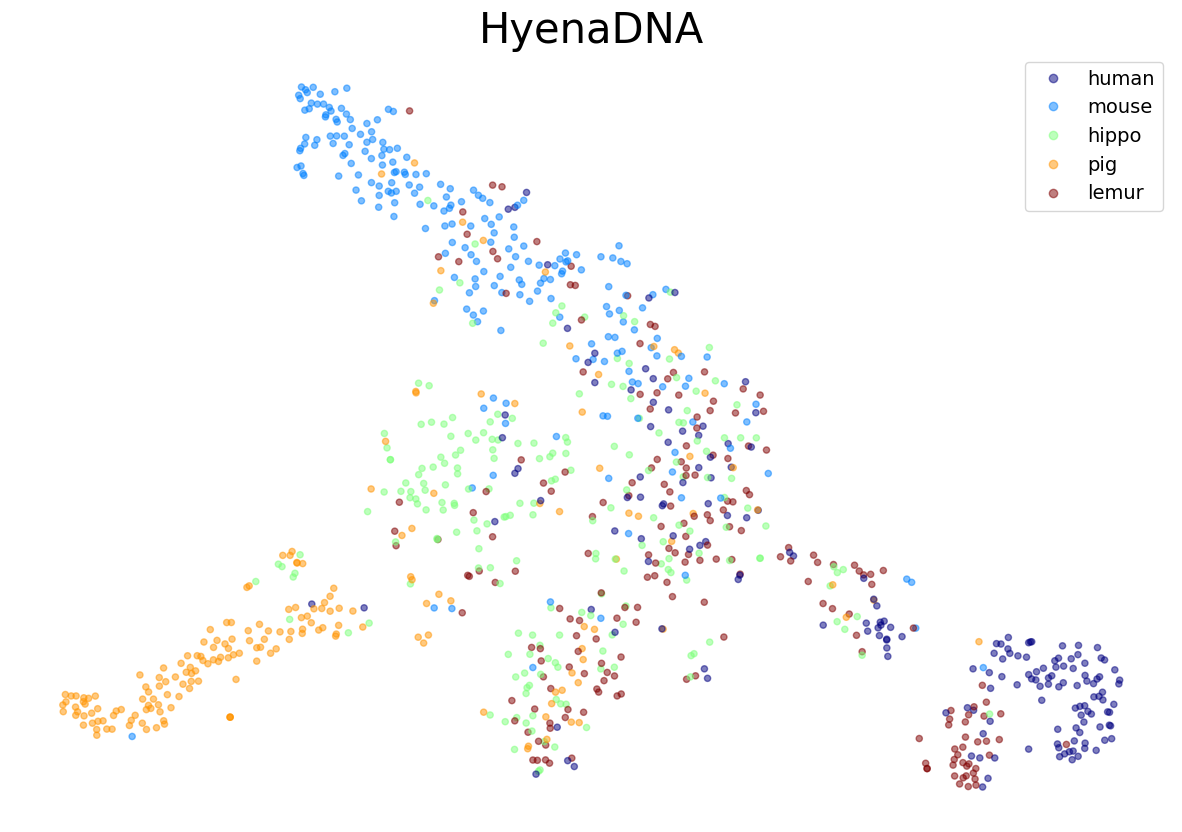

In [4]:

from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
# from umap import UMAP
print(all_embeddings_hyena[0].shape)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
all_embeddings_2d_hyena = tsne.fit_transform(np.array(all_embeddings_hyena))
plt.clf()
needed_folders_names = ['human','mouse', 'hippo','pig', 'lemur']
fig = plt.figure(figsize=(15, 10))
#remove axis and boundaries
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
s = plt.scatter(*all_embeddings_2d_hyena.T, c=species_labels_hyena, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
plt.legend(s.legend_elements()[0], list(map(lambda n: n.split('_')[-1], needed_folders_names)), fontsize=14)
plt.title('HyenaDNA', fontsize=30)
plt.savefig('HyenaDNA.pdf')
plt.show()

In [5]:
import torch
from transformers import AutoModel,AutoTokenizer
state_dict='/liuzicheng/ljh/hyena-dna/weight/dnabert2'
tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
dnabert2=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
DNABERT2_decoder=torch.nn.Linear(768,5).to('cuda')
checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-04-07/02-10-10-895046/checkpoints/val/accuracy.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "model.backbone."
    )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "decoder.0.output_transform."
    )
#print model.keys()
dnabert2.load_state_dict(checkpoint,strict=False)
DNABERT2_decoder.load_state_dict(checkpoint,strict=False)
dnabert2.eval()
DNABERT2_decoder.eval()
all_embeddings_dnabert2=[]
species_labels_dnabert2=[]
batch_size=1000
#load data
equal=0
for i in range (batch_size):
    #no gradient
    with torch.no_grad():
        data,target=sample_sequence(species,chromosomes,species_weights,chromosome_weights,fastas,max_length,tokenizer,'dnabert2')
        data=data.unsqueeze(0).to('cuda')
        # print(data.shape)
        # print(target)


        logits=dnabert2(input_ids=data,output_hidden_states=True,)[0]
        
        
        logits=restrict(logits)
        all_embeddings_dnabert2.append(logits.squeeze(0).squeeze(0).detach().cpu())
        species_labels_dnabert2.append(target)
        #print shape of logits
        output=DNABERT2_decoder(logits)
        output=output.squeeze(0)
        #output argmax
        predicted_label=torch.argmax(output,dim=1)
        equal+=int(predicted_label==target)
        print(i)
#calculate accuracy
accuracy=equal/batch_size
accuracy

/root/.cache/huggingface/modules/transformers_modules/dnabert2/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at /liuzicheng/ljh/hyena-dna/weight/dnabert2 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/root/.cache/huggingface/modules/transformers_modules/dnabert2/bert_layers.py:433: UserWarning: Increasing alibi size from 512 to 2999
  warnings.warn(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0.715

torch.Size([768])


<Figure size 640x480 with 0 Axes>

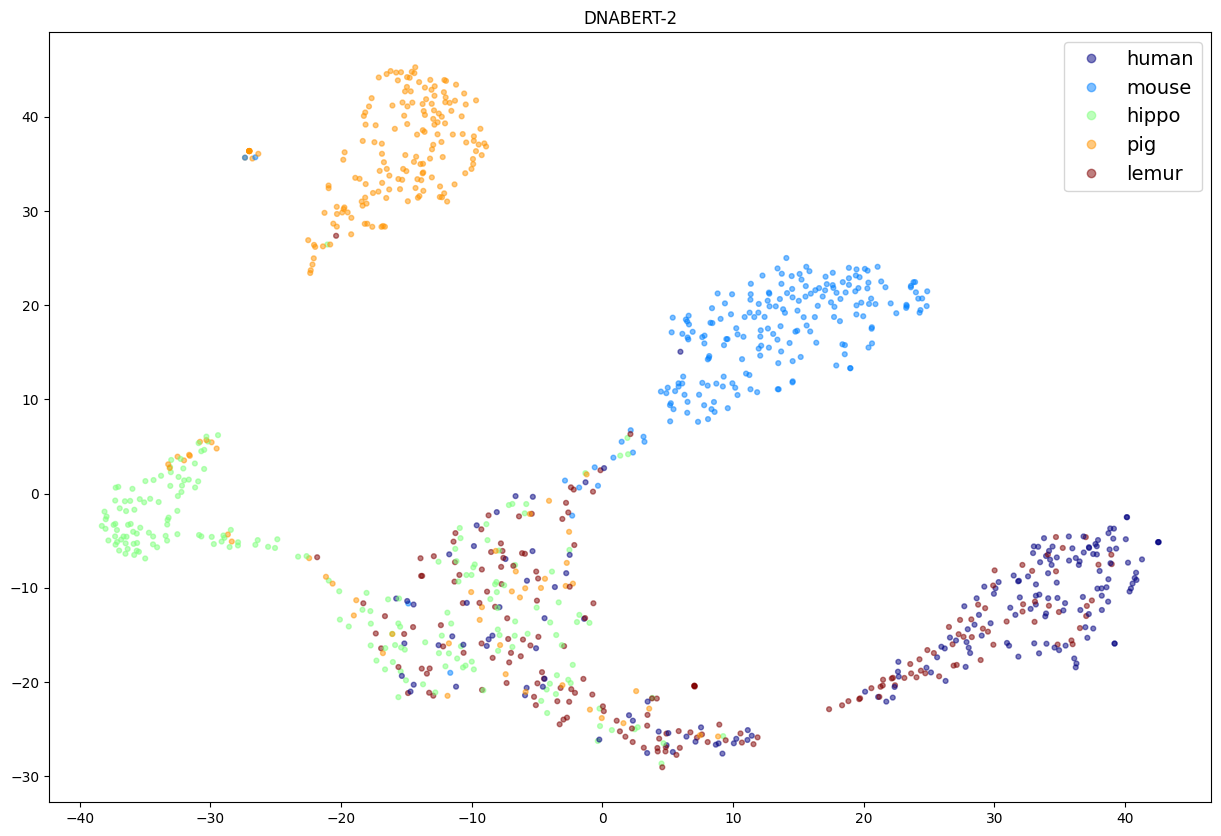

In [6]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
# from umap import UMAP
print(all_embeddings_dnabert2[0].shape)
tsne2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
all_embeddings_2d_DNABERT = tsne2.fit_transform(np.array(all_embeddings_dnabert2))
plt.clf()
needed_folders_names = ['human','mouse', 'hippo','pig', 'lemur']
fig = plt.figure(figsize=(15, 10))
s = plt.scatter(*all_embeddings_2d_DNABERT.T, c=species_labels_dnabert2, s=12, alpha=.5, cmap=mpl.colormaps['jet'])
plt.legend(s.legend_elements()[0], list(map(lambda n: n.split('_')[-1], needed_folders_names)), fontsize=14)

plt.title('DNABERT-2')
plt.savefig('DNABERT-2.pdf')
plt.show()

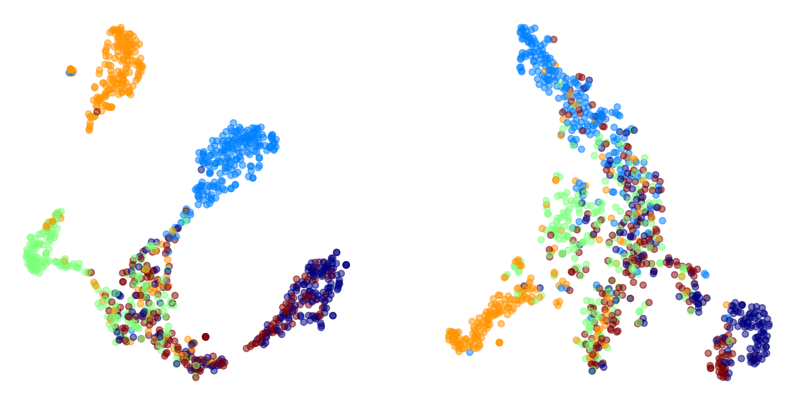

In [7]:
#plot two figures side by side

import matplotlib.pyplot as plt

plt, (fig1,fig2)= plt.subplots(1, 2, figsize=(10, 5))

# plot the first figure
fig1.scatter(*all_embeddings_2d_DNABERT.T, c=species_labels_dnabert2, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
fig2.scatter(*all_embeddings_2d_hyena.T, c=species_labels_hyena, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
#remove axis and boundary for both figure
fig1.axis('off')
fig2.axis('off')
plt.show()


In [8]:
import torch
from transformers import AutoModel,AutoTokenizer
state_dict='/liuzicheng/ljh/hyena-dna/weight/genalm/gena-lm-bigbird-base-t2t'
tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
genalm=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
genalm_decoder=torch.nn.Linear(768,5).to('cuda')
checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-04-07/04-46-00-609768/checkpoints/val/accuracy.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "model.backbone."
    )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "decoder.0.output_transform."
    )
#print model.keys()
genalm.load_state_dict(checkpoint,strict=False)
genalm_decoder.load_state_dict(checkpoint,strict=False)
genalm.eval()
genalm_decoder.eval()
all_embeddings_genalm=[]
species_labels_genalm=[]
batch_size=1000
#load data
equal=0
for i in range (batch_size):
    #no gradient
    with torch.no_grad():
        data,target=sample_sequence(species,chromosomes,species_weights,chromosome_weights,fastas,max_length,tokenizer,'genalm')
        data=data.unsqueeze(0).to('cuda')
        # print(data.shape)
        # print(target)


        logits=genalm(input_ids=data, output_hidden_states=True,).hidden_states[-1]
        
        
        logits=restrict(logits)
        all_embeddings_genalm.append(logits.squeeze(0).squeeze(0).detach().cpu())
        species_labels_genalm.append(target)
        #print shape of logits
        output=genalm_decoder(logits)
        output=output.squeeze(0)
        #output argmax
        predicted_label=torch.argmax(output,dim=1)
        equal+=int(predicted_label==target)
        print(i)
#calculate accuracy
accuracy=equal/batch_size
accuracy

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Input ids are automatically padded from 2999 to 3008 to be a multiple of `config.block_size`: 64


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0.69

torch.Size([768])


<Figure size 640x480 with 0 Axes>

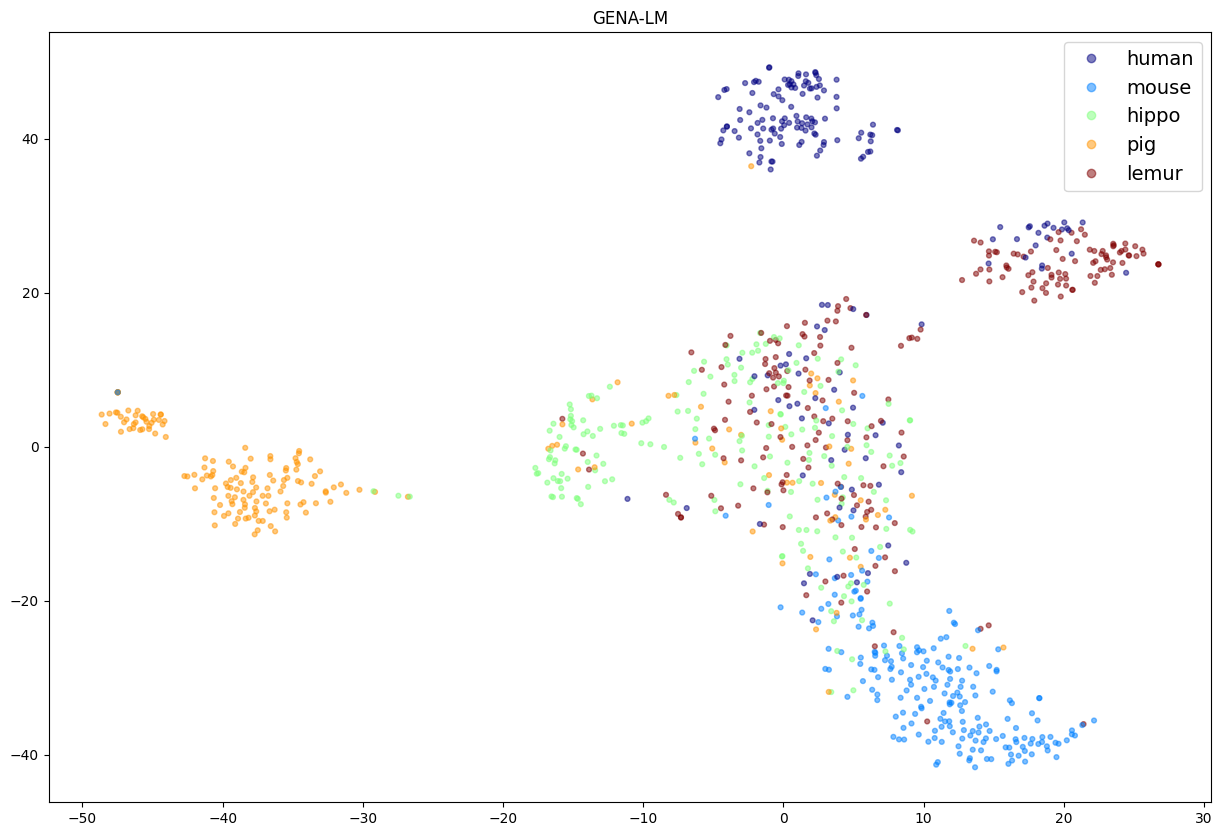

In [9]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
# from umap import UMAP
print(all_embeddings_genalm[0].shape)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
all_embeddings_2d_gena = tsne.fit_transform(np.array(all_embeddings_genalm))
plt.clf()
needed_folders_names = ['human','mouse', 'hippo','pig', 'lemur']
fig = plt.figure(figsize=(15, 10))
s = plt.scatter(*all_embeddings_2d_gena.T, c=species_labels_genalm, s=12, alpha=.5, cmap=mpl.colormaps['jet'])
plt.legend(s.legend_elements()[0], list(map(lambda n: n.split('_')[-1], needed_folders_names)), fontsize=14)
plt.title('GENA-LM')
plt.savefig('GENA-LM.pdf')
plt.show()

In [10]:
import torch
from transformers import AutoModel,AutoTokenizer,AutoModelForMaskedLM
state_dict='/liuzicheng/ljh/hyena-dna/weight/nt/nucleotide-transformer-v2-500m-multi-species'
tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
NT=AutoModelForMaskedLM.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
NT_decoder=torch.nn.Linear(1024,5).to('cuda')
checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-04-07/06-43-55-513734/checkpoints/val/accuracy.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "model.backbone."
    )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "decoder.0.output_transform."
    )
#print model.keys()
NT.load_state_dict(checkpoint,strict=False)
NT_decoder.load_state_dict(checkpoint,strict=False)
NT.eval()
NT_decoder.eval()
all_embeddings_NT=[]
species_labels_NT=[]
batch_size=1000
#load data
equal=0
for i in range (batch_size):
    #no gradient
    with torch.no_grad():
        data,target=sample_sequence(species,chromosomes,species_weights,chromosome_weights,fastas,max_length,tokenizer,'NT')
        data=data.unsqueeze(0).to('cuda')
        # print(data.shape)
        # print(target)


        logits=NT(data,output_hidden_states=True)['hidden_states'][-1] 
        
        
        logits=restrict(logits)
        all_embeddings_NT.append(logits.squeeze(0).squeeze(0).detach().cpu())
        species_labels_NT.append(target)
        #print shape of logits
        output=NT_decoder(logits)
        output=output.squeeze(0)
        #output argmax
        predicted_label=torch.argmax(output,dim=1)
        equal+=int(predicted_label==target)
        print(i)
#calculate accuracy
accuracy=equal/batch_size
accuracy

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0.767

torch.Size([1024])


<Figure size 640x480 with 0 Axes>

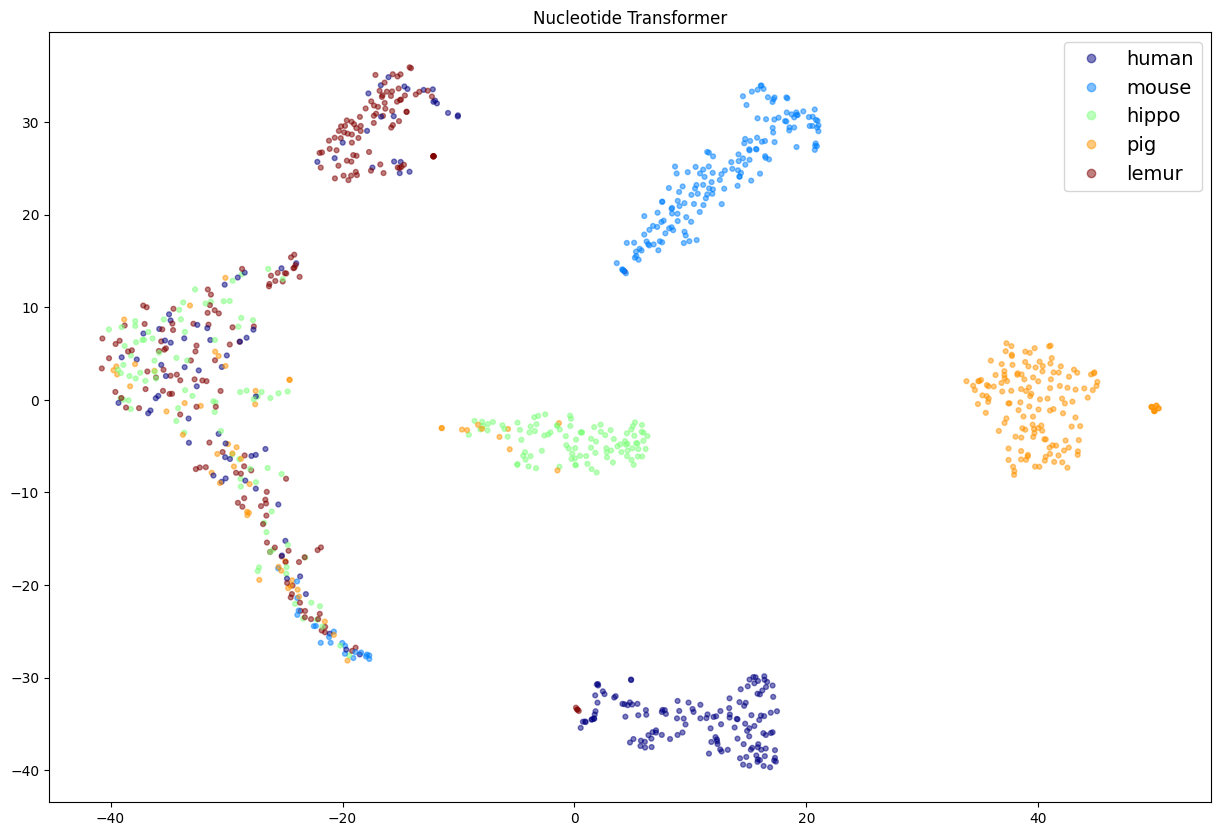

In [11]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
# from umap import UMAP
print(all_embeddings_NT[0].shape)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
all_embeddings_2d_NT = tsne.fit_transform(np.array(all_embeddings_NT))
plt.clf()
fig = plt.figure(figsize=(15, 10))

needed_folders_names = ['human','mouse', 'hippo','pig', 'lemur']
s = plt.scatter(*all_embeddings_2d_NT.T, c=species_labels_NT, s=12, alpha=.5, cmap=mpl.colormaps['jet'])
plt.legend(s.legend_elements()[0], list(map(lambda n: n.split('_')[-1], needed_folders_names)), fontsize=14)
plt.title('Nucleotide Transformer')
plt.savefig('Nucleotide Transformer.pdf')
plt.show()

In [12]:
import torch
from transformers import AutoModel,AutoTokenizer,AutoModelForMaskedLM
state_dict='/liuzicheng/ljh/hyena-dna/weight/mamba'
tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
mamba=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
mamba_decoder=torch.nn.Linear(256,5).to('cuda')
checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-04-26/14-25-29-745801/checkpoints/val/accuracy.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "model.backbone."
    )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
        checkpoint, "decoder.0.output_transform."
    )
#print model.keys()
mamba.load_state_dict(checkpoint,strict=False)
mamba_decoder.load_state_dict(checkpoint,strict=False)
mamba.eval()
mamba_decoder.eval()
all_embeddings_mamba=[]
species_labels_mamba=[]
batch_size=1000
#load data
equal=0
for i in range (batch_size):
    #no gradient
    with torch.no_grad():
        data,target=sample_sequence(species,chromosomes,species_weights,chromosome_weights,fastas,max_length,tokenizer,'NT')
        data=data.unsqueeze(0).to('cuda')
        # print(data.shape)
        # print(target)


        logits=mamba(data,output_hidden_states=True).last_hidden_state
        
        
        logits=restrict(logits)
        all_embeddings_mamba.append(logits.squeeze(0).squeeze(0).detach().cpu())
        species_labels_mamba.append(target)
        #print shape of logits
        output=mamba_decoder(logits)
        output=output.squeeze(0)
        #output argmax
        predicted_label=torch.argmax(output,dim=1)
        equal+=int(predicted_label==target)
        print(i)
#calculate accuracy
accuracy=equal/batch_size
accuracy

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0.703

torch.Size([256])


<Figure size 640x480 with 0 Axes>

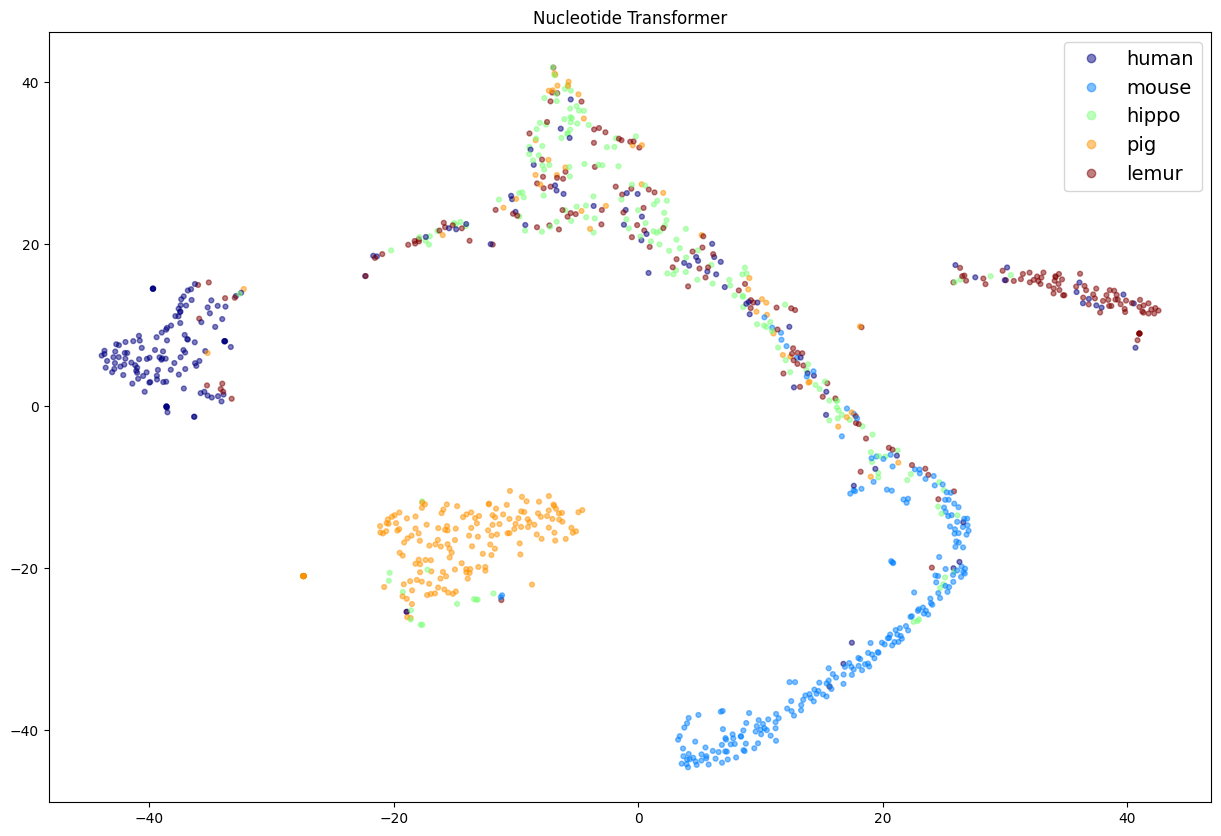

In [13]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
# from umap import UMAP
print(all_embeddings_mamba[0].shape)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
all_embeddings_2d_mamba = tsne.fit_transform(np.array(all_embeddings_mamba))
plt.clf()
fig = plt.figure(figsize=(15, 10))

needed_folders_names = ['human','mouse', 'hippo','pig', 'lemur']
s = plt.scatter(*all_embeddings_2d_mamba.T, c=species_labels_mamba, s=12, alpha=.5, cmap=mpl.colormaps['jet'])
plt.legend(s.legend_elements()[0], list(map(lambda n: n.split('_')[-1], needed_folders_names)), fontsize=14)
plt.title('Nucleotide Transformer')
plt.savefig('Nucleotide Transformer.pdf')
plt.show()

/tmp/ipykernel_71604/410053905.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  type1=fig1.scatter(*all_embeddings_2d_DNABERT.T, c=species_labels_dnabert2_color, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
/tmp/ipykernel_71604/410053905.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  fig2.scatter(*all_embeddings_2d_hyena.T, c=species_labels_hyena_color, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
/tmp/ipykernel_71604/410053905.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  fig3.scatter(*all_embeddings_2d_gena.T, c=species_labels_genalm_color, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
/tmp/ipykernel_71604/410053905.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  fig4.scatter(*all_embeddings_2d_NT.T, c=species_labels_NT_color, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
/tmp/ipykernel_7160

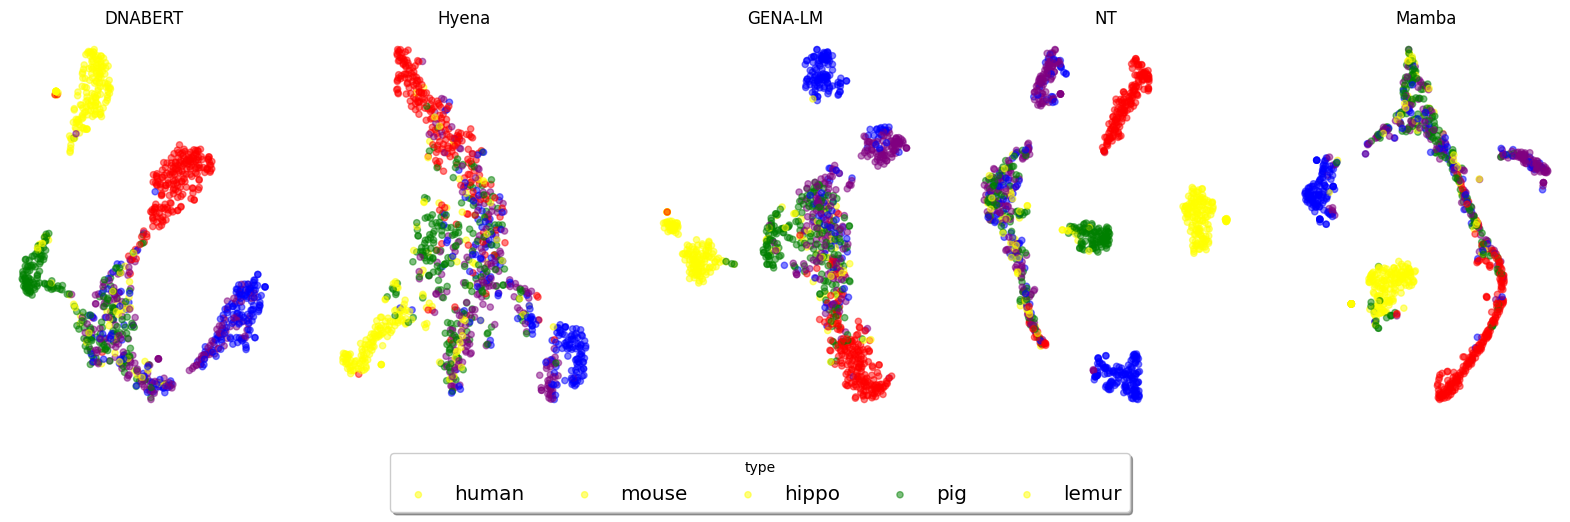

In [14]:
import matplotlib.pyplot as plt

plt, (fig1,fig2,fig3,fig4,fig5)= plt.subplots(1, 5, figsize=(20, 5))
species=['human','mouse','hippo','pig','lemur']
color_map={0:'blue',1:'red',2:'green',3:'yellow',4:'purple'}

#map list of int to list of string
species_labels_dnabert2_color = [color_map[i] for i in species_labels_dnabert2]
species_labels_hyena_color = [color_map[i] for i in species_labels_hyena]
species_labels_genalm_color = [color_map[i] for i in species_labels_genalm]
species_labels_NT_color = [color_map[i] for i in species_labels_NT]
species_labels_mamba_color = [color_map[i] for i in species_labels_mamba]

# plot the first figure
type1=fig1.scatter(*all_embeddings_2d_DNABERT.T, c=species_labels_dnabert2_color, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
fig2.scatter(*all_embeddings_2d_hyena.T, c=species_labels_hyena_color, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
fig3.scatter(*all_embeddings_2d_gena.T, c=species_labels_genalm_color, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
fig4.scatter(*all_embeddings_2d_NT.T, c=species_labels_NT_color, s=20, alpha=.5, cmap=mpl.colormaps['jet'])
fig5.scatter(*all_embeddings_2d_mamba.T, c=species_labels_mamba_color, s=20, alpha=.5, cmap=mpl.colormaps['jet'])

fig1.set_title('DNABERT')
fig2.set_title('Hyena')
fig3.set_title('GENA-LM')
fig4.set_title('NT')
fig5.set_title('Mamba')
#remove axis and boundary for both figure
fig1.axis('off')
fig2.axis('off')
fig3.axis('off')
fig4.axis('off')
fig5.axis('off')
#show the label of speciesax

#add color note for the first figure
species_color_map = {'human': '0','mouse': '1', 'hippo': '2', 'pig': '3', 'lemur': '4'}


species=['human','mouse','hippo','pig','lemur']
#map species to color


#add colorbar for the first figure





plt.legend(species,ncol=5,
                    loc="lower center", title="type",
                    bbox_to_anchor=(0.5, -0.1),
                    fancybox=True, shadow=True,
                    fontsize='x-large')
plt.show()

(2, 1000)


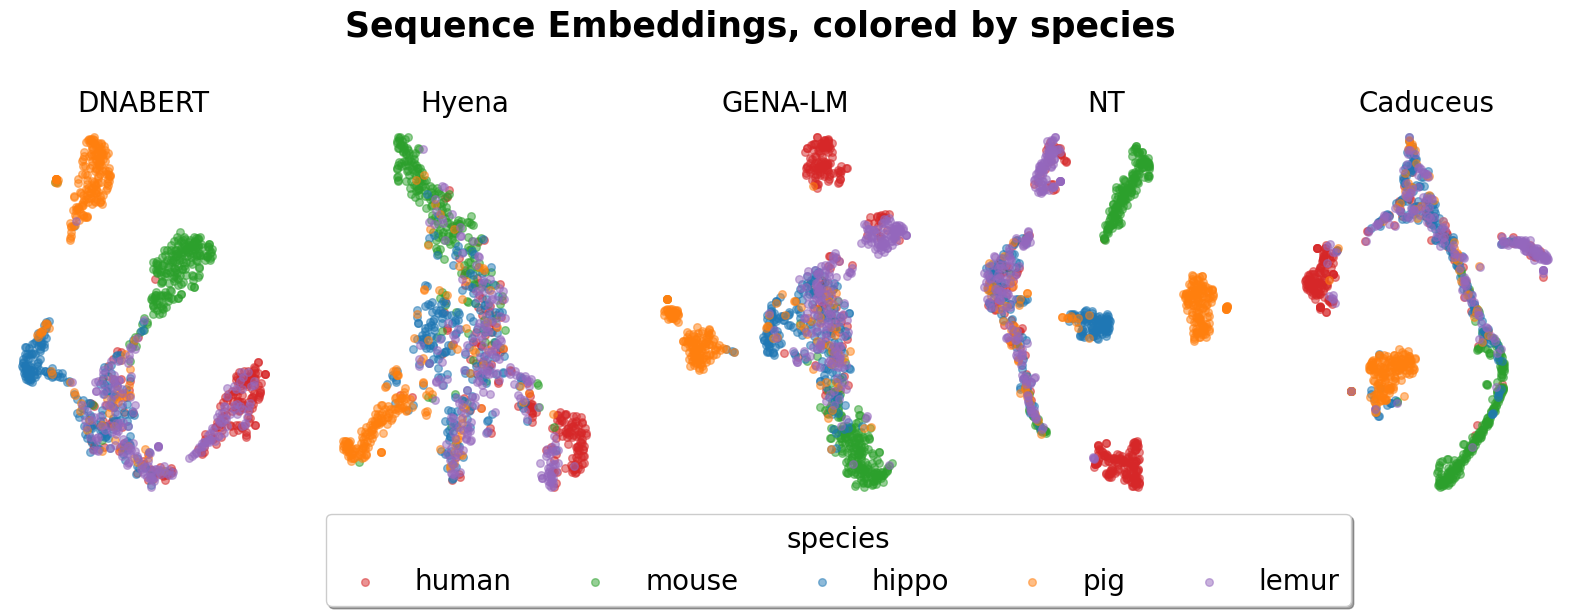

In [18]:
from matplotlib import pyplot as plt

figure,(axes1, axes2, axes3, axes4, axes5)=plt.subplots(1, 5,figsize=(20,5))
axes1.axis('off')
axes2.axis('off')
axes3.axis('off')
axes4.axis('off')
axes5.axis('off')

axes1.set_title('DNABERT',fontsize=20)
axes2.set_title('Hyena',fontsize=20)
axes3.set_title('GENA-LM',fontsize=20)
axes4.set_title('NT',fontsize=20)
axes5.set_title('Caduceus',fontsize=20)

type0_x = []
type0_y = []
type1_x = []
type1_y = []
type2_x = []
type2_y = []
type3_x = []
type3_y = []
type4_x = []
type4_y = []

species=['human','mouse','hippo','pig','lemur']
print(all_embeddings_2d_DNABERT.T.shape)
for i in range(len(species_labels_dnabert2)):
    if species_labels_dnabert2[i] == 0:
        type0_x.append(all_embeddings_2d_DNABERT[i][0])
        type0_y.append(all_embeddings_2d_DNABERT[i][1])
    elif species_labels_dnabert2[i] == 1:
        type1_x.append(all_embeddings_2d_DNABERT[i][0])
        type1_y.append(all_embeddings_2d_DNABERT[i][1])
    elif species_labels_dnabert2[i] == 2:
        type2_x.append(all_embeddings_2d_DNABERT[i][0])
        type2_y.append(all_embeddings_2d_DNABERT[i][1])
    elif species_labels_dnabert2[i] == 3:
        type3_x.append(all_embeddings_2d_DNABERT[i][0])
        type3_y.append(all_embeddings_2d_DNABERT[i][1])
    elif species_labels_dnabert2[i] == 4:
        type4_x.append(all_embeddings_2d_DNABERT[i][0])
        type4_y.append(all_embeddings_2d_DNABERT[i][1])

type1 = axes1.scatter(type0_x, type0_y, s=30,alpha=.5, c='tab:red')
type2 = axes1.scatter(type1_x, type1_y, s=30,alpha=.5, c='tab:green')
type3 = axes1.scatter(type2_x, type2_y, s=30,alpha=.5, c='tab:blue')
type4 = axes1.scatter(type3_x, type3_y, s=30,alpha=.5, c='tab:orange')
type5 = axes1.scatter(type4_x, type4_y, s=30,alpha=.5, c='tab:purple')


type0_x = []
type0_y = []
type1_x = []
type1_y = []
type2_x = []
type2_y = []
type3_x = []
type3_y = []
type4_x = []
type4_y = []
for i in range(len(species_labels_hyena)):
    if species_labels_hyena[i] == 0:
        type0_x.append(all_embeddings_2d_hyena[i][0])
        type0_y.append(all_embeddings_2d_hyena[i][1])
    elif species_labels_hyena[i] == 1:
        type1_x.append(all_embeddings_2d_hyena[i][0])
        type1_y.append(all_embeddings_2d_hyena[i][1])
    elif species_labels_hyena[i] == 2:
        type2_x.append(all_embeddings_2d_hyena[i][0])
        type2_y.append(all_embeddings_2d_hyena[i][1])
    elif species_labels_hyena[i] == 3:
        type3_x.append(all_embeddings_2d_hyena[i][0])
        type3_y.append(all_embeddings_2d_hyena[i][1])
    elif species_labels_hyena[i] == 4:
        type4_x.append(all_embeddings_2d_hyena[i][0])
        type4_y.append(all_embeddings_2d_hyena[i][1])

type1 = axes2.scatter(type0_x, type0_y, s=30,alpha=.5, c='tab:red')
type2 = axes2.scatter(type1_x, type1_y, s=30,alpha=.5, c='tab:green')
type3 = axes2.scatter(type2_x, type2_y, s=30,alpha=.5, c='tab:blue')
type4 = axes2.scatter(type3_x, type3_y, s=30,alpha=.5, c='tab:orange')
type5 = axes2.scatter(type4_x, type4_y, s=30,alpha=.5, c='tab:purple')


type0_x = []
type0_y = []
type1_x = []
type1_y = []
type2_x = []
type2_y = []
type3_x = []
type3_y = []
type4_x = []
type4_y = []
for i in range(len(species_labels_genalm)):
    if species_labels_genalm[i] == 0:
        type0_x.append(all_embeddings_2d_gena[i][0])
        type0_y.append(all_embeddings_2d_gena[i][1])
    elif species_labels_genalm[i] == 1:
        type1_x.append(all_embeddings_2d_gena[i][0])
        type1_y.append(all_embeddings_2d_gena[i][1])
    elif species_labels_genalm[i] == 2:
        type2_x.append(all_embeddings_2d_gena[i][0])    
        type2_y.append(all_embeddings_2d_gena[i][1])
    elif species_labels_genalm[i] == 3:
        type3_x.append(all_embeddings_2d_gena[i][0])
        type3_y.append(all_embeddings_2d_gena[i][1])
    elif species_labels_genalm[i] == 4:
        type4_x.append(all_embeddings_2d_gena[i][0])
        type4_y.append(all_embeddings_2d_gena[i][1])

type1 = axes3.scatter(type0_x, type0_y, s=30,alpha=.5, c='tab:red')
type2 = axes3.scatter(type1_x, type1_y, s=30,alpha=.5, c='tab:green')
type3 = axes3.scatter(type2_x, type2_y, s=30,alpha=.5, c='tab:blue')
type4 = axes3.scatter(type3_x, type3_y, s=30,alpha=.5, c='tab:orange')
type5 = axes3.scatter(type4_x, type4_y, s=30,alpha=.5, c='tab:purple')


type0_x = []
type0_y = []
type1_x = []
type1_y = []
type2_x = []
type2_y = []
type3_x = []
type3_y = []
type4_x = []
type4_y = []
for i in range(len(species_labels_NT)):
    if species_labels_NT[i] == 0:
        type0_x.append(all_embeddings_2d_NT[i][0])
        type0_y.append(all_embeddings_2d_NT[i][1])
    elif species_labels_NT[i] == 1:
        type1_x.append(all_embeddings_2d_NT[i][0])
        type1_y.append(all_embeddings_2d_NT[i][1])
    elif species_labels_NT[i] == 2:
        type2_x.append(all_embeddings_2d_NT[i][0])
        type2_y.append(all_embeddings_2d_NT[i][1])
    elif species_labels_NT[i] == 3:
        type3_x.append(all_embeddings_2d_NT[i][0])
        type3_y.append(all_embeddings_2d_NT[i][1])
    elif species_labels_NT[i] == 4:
        type4_x.append(all_embeddings_2d_NT[i][0])
        type4_y.append(all_embeddings_2d_NT[i][1])

type1 = axes4.scatter(type0_x, type0_y, s=30,alpha=.5, c='tab:red')
type2 = axes4.scatter(type1_x, type1_y, s=30,alpha=.5, c='tab:green')
type3 = axes4.scatter(type2_x, type2_y, s=30,alpha=.5, c='tab:blue')
type4 = axes4.scatter(type3_x, type3_y, s=30,alpha=.5, c='tab:orange')
type5 = axes4.scatter(type4_x, type4_y, s=30,alpha=.5, c='tab:purple')


type0_x = []
type0_y = []
type1_x = []
type1_y = []
type2_x = []
type2_y = []
type3_x = []
type3_y = []
type4_x = []
type4_y = []
for i in range(len(species_labels_mamba)):
    if species_labels_mamba[i] == 0:
        type0_x.append(all_embeddings_2d_mamba[i][0])
        type0_y.append(all_embeddings_2d_mamba[i][1])
    
    elif species_labels_mamba[i] == 1:
        type1_x.append(all_embeddings_2d_mamba[i][0])
        type1_y.append(all_embeddings_2d_mamba[i][1])
    
    elif species_labels_mamba[i] == 2:
        type2_x.append(all_embeddings_2d_mamba[i][0])
        type2_y.append(all_embeddings_2d_mamba[i][1])
    
    elif species_labels_mamba[i] == 3:
        type3_x.append(all_embeddings_2d_mamba[i][0])
        type3_y.append(all_embeddings_2d_mamba[i][1])
    
    elif species_labels_mamba[i] == 4:
        type4_x.append(all_embeddings_2d_mamba[i][0])
        type4_y.append(all_embeddings_2d_mamba[i][1])

type1 = axes5.scatter(type0_x, type0_y, s=30,alpha=.5, c='tab:red')
type2 = axes5.scatter(type1_x, type1_y, s=30,alpha=.5, c='tab:green')
type3 = axes5.scatter(type2_x, type2_y, s=30,alpha=.5, c='tab:blue')
type4 = axes5.scatter(type3_x, type3_y, s=30,alpha=.5, c='tab:orange')
type5 = axes5.scatter(type4_x, type4_y, s=30,alpha=.5, c='tab:purple')
    
plt.suptitle('Sequence Embeddings, colored by species',fontsize=25,y=1.1,fontweight='bold')
# plt.legend((type1, type2, type3, type4, type5), species, loc="lower center")
plt.legend((type1, type2, type3, type4, type5), species,ncol=5,
                    loc="lower center", title="species",title_fontsize=20,
                    bbox_to_anchor=(-1.7, -0.3),
                    fancybox=True, shadow=True,
                    fontsize=20)
# plt.show()
plt.savefig('sequence_embedding.pdf',bbox_inches = 'tight')


